## Corona plotting notebook
@jeffluppes (https://github.com/jeffluppes) Mar 17 2020

This is nothing more than a quick and dirty script I spent an hour on that does the following:

* downloads a public map of Dutch municipalities (Gemeentes)
* scrapes the RIVM website for data on the daily cases of Covid-19
* Does limited cleaning 
* Stores raw data to your disk as a csv
* Merges the public data with the corona data
* Plots a pretty graph to show where the cases are
* Stores the pretty graph 

Stay safe people, and pay attention to the instructions by the Government and the RIVM. 

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import date

In [2]:
# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)

In [3]:
url="https://www.rivm.nl/coronavirus-kaart-van-nederland"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

# grab the csv data elment
csvdata = soup.find("div", {"id": "csvData"}).text

# remove the leading \n
csvdata = csvdata[1:]

In [4]:
#store file to disk

# this generates a day stamp - e.g. 17 mar 2020
today = date.today().strftime("%d-%b-%Y")
with open('corona_'+today+'.csv','w', encoding='utf-8') as file:
    file.write(csvdata)

In [5]:
#read corona data from data frame
corona_df = pd.read_csv('corona_'+today+'.csv', sep=';')

# delete the columns with negative Gemnr
corona_df = corona_df[(corona_df['Gemnr'] >= 0)]

In [6]:
#lets check how the data looks
corona_df.head(2)

,Gemeente,Gemnr,Aantal
2,Aalsmeer,358,3.0
3,Albrandswaard,613,2.0


In [7]:
# and how our public data on municipialities looks
municipal_boundaries.head(2)

,id,statcode,statnaam,jrstatcode,rubriek,geometry
0,cbs_gemeente_2017_gegeneraliseerd.227606,GM0003,Appingedam,2017GM0003,gemeente,"POLYGON ((254580.674 594573.506, 254695.946 59..."
1,cbs_gemeente_2017_gegeneraliseerd.227607,GM0005,Bedum,2017GM0005,gemeente,"POLYGON ((235432.131 595115.625, 235465.695 59..."


In [8]:
# Link data from Statistics Netherlands to geodata
municipal_boundaries = pd.merge(municipal_boundaries, corona_df,
                               left_on = "statnaam", 
                               right_on = "Gemeente",
                               how = "outer")
municipal_boundaries['Aantal'] = municipal_boundaries['Aantal'].fillna(0)

Text(0.5, 1, 'Hoeveelheid Corona-Gevallen per gemeente')

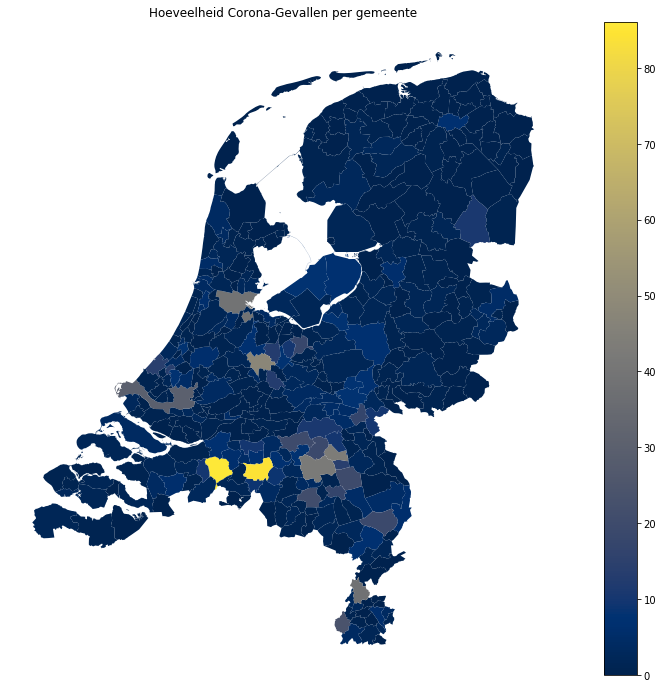

In [9]:
# Create a thematic map
p = municipal_boundaries.plot(column='Aantal',
                             cmap = 'cividis',
                             legend = True,
                             figsize = (16,12))
p.axis('off')
p.set_title('Hoeveelheid Corona-Gevallen per gemeente')

In [10]:
#store the map
p.figure.savefig('corona_cases_netherlands'+today+'.png')